In [1]:
"""
OIII5007 fits on BOSS Seyferts SN>50

Linear Continuum

Author: Alan Nguyen

02-01-2020
"""

'\nOIII5007 fits on BOSS Seyferts SN>50\n\nLinear Continuum\n\nAuthor: Alan Nguyen\n\n02-01-2020\n'

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, Column
from scipy.optimize import curve_fit, leastsq
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
import os
import math as m
from astropy import constants as const
import time
from BOSS_func_v6 import *

In [3]:
hdul = fits.open('seyferts_BOSS_HSN_v3.fits') #open the file containing the list of spectra with SN>50, cleaned 
seyferts = hdul[1].data #take only the data, not the header
hdul.close() 

In [4]:
#
#create a dictionary containing important parameters and the spectrum plots for the full wavelength range
#

specs = {} #create a dictionary to store the spectra
count = 0 #for a loading bar lmao

for l in seyferts: #for each line (each spectrum) in the file take the following
    filename = l['FILENAME'] #take the filename given in the FILENAME column of the data
    filenamefits = l['FILENAME'] + '.fits' #append .fits to call the file
    filedir = os.path.join('highSNspecs', str(l['PLATE']), filenamefits) #add directories to pull the file from the corrct folder
    
    ###############################
    ###############################
    
    z = l['Z'] # z = (observed wavelength - rest wavelength) / (rest wavelength)
    k = 1 + z  # simply rearrange above formula, rest wavelength = observed wavelength / k
    
    ###############################
    ###############################
    
    hdul = fits.open(filedir) #using above directory open fits for the specific spectra
    data = hdul[1].data #again take only data not the header
    wave = 10 ** data['loglam'] #convert wavelength back to linear scale
    flux = data['flux'] #take fluxden
    inverse_variance = data['ivar'] #take inverse variance
    error = np.sqrt( 1 / inverse_variance ) #convert to standard deviation
    hdul.close()
    
    ###############################
    ###############################
    
    SN = l['SN'] #take signal to noise
    CHISQ = l['CHISQ'] #take CHISQ for bad data comparisons
    
    ###############################
    ###############################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(wave) #0 
    tempdat.append(flux) #1
    tempdat.append(k)    #2
    tempdat.append(error)#3
    tempdat.append(SN)   #4
    tempdat.append(CHISQ)#5
    
    specs.update({filename:tempdat})
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(seyferts)), end = "") #progress bar to keep track of progress

    

Complete: 18/410

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


Complete: 410/410

In [5]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

trimmed_specs = {}

count = 0 #for a loading bar lmao

bad_specs = []

for s in specs: #for every spectrum generated in previous block
    wave = specs[s][0] #extract wavelength array
    fluxden = specs[s][1] #extract flux density array
    k = specs[s][2] #z + 1, to account for redshift during the trimming
    error = specs[s][3] #extract flux density error array
    SN = specs[s][4] #extract signal to noise
    
    ###############################
    ###############################

    OIII_select = (wave > 4980*k) & (wave < 5030*k) #create parameter to trim the data for the [OIII]5007 line

    OIII_wave = wave[OIII_select] #select for [OIII]5007
    OIII_fluxden = fluxden[OIII_select] #select for [OIII]5007
    OIII_error = error[OIII_select] #select for [OIII]5007
    
    ###############################
    ###############################
    
    inf_indices = np.where(OIII_error == np.inf) #take indices where error is infinity for some reason?
    
    mean_error = np.mean(OIII_error[OIII_error != np.inf]) #take the mean error from the [OIII]5007 slice
    
    for i in inf_indices[0]: #replace all the infinity indices with the mean error
        OIII_error[i] = mean_error
    
    ###############################
    ###############################
    
    OIII_fluxden_scale = np.max(OIII_fluxden) #take the scale factor as the maximum flux density in this region
    
    OIII_norm_fluxden = OIII_fluxden / OIII_fluxden_scale #normalize so the peak is at one
    OIII_norm_error = OIII_error / OIII_fluxden_scale #scale the error to preserve relationship with flux density
    
    ###############################
    ###############################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(OIII_wave)          #0 wavelength
    tempdat.append(OIII_norm_fluxden)  #1 normalized flux density
    tempdat.append(k)                  #2 k = z + 1
    tempdat.append(OIII_norm_error)    #3 normalized flux density error
    tempdat.append(SN)                 #4 Signal to Noise Ratio
    tempdat.append(CHISQ)              #5 given chi squared
    tempdat.append(OIII_fluxden_scale) #6 maximum flux density used to scale normalized flux density
    
    trimmed_specs.update({s:tempdat}) #update the trimmed dictionary with a smaller dataset
    
    ###############################
    ###############################
    
    if OIII_fluxden_scale == 0: #add to list of "flat" spectra
        bad_specs.append(s)
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
for s in bad_specs: #remove bad spectra from the trimmed dictionary
    trimmed_specs.pop(s, None)

Complete: 410/410

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


In [6]:
#START HERE WITH FITTING FUNCTION

In [6]:
preset_parameters = {} #called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID, fit
TRIALS = 100 #set number of trials for the Monte-Carlo error
MC_flags = np.zeros((TRIALS, len(trimmed_specs)))
count = 0
final_results = {}
start_time = time.process_time()

for s in trimmed_specs: #loop and use the fit on all the trimmed specs
    
    used_preset = False #by default use the generic initial conditions

    OIII_wave = trimmed_specs[s][0] #array with wavelength values for the current spectrum in angstrom
    OIII_fluxden = trimmed_specs[s][1] #array with corresponding flux density values
    k = trimmed_specs[s][2] #corresponding z + 1 value
    OIII_error = trimmed_specs[s][3] #array with corresponding flux density error values
    
    ###############################
    ###############################
    
    specific_presets = {} #prepare a dictionary with velocity means corrected for the current spectrum's k value

    for p in preset_parameters: #for every key in the preset parameters
        
    ###############################
    ###############################
        
        k_corrected_parameters = preset_parameters[p][0] #take the parameters first 
        
    ###############################
    
#     Using z = v / c
    
#     z1 / v1 = c = z2 / v2
    
#     v2 = (z2 / z1) * v1
    
#     z2 = k_spectrum - 1

#     z1 = k_fit - 1
    
    ###############################
        
        k_corrected_parameters[1] = ((k - 1)/(preset_parameters[p][1] - 1)) * k_corrected_parameters[1]
        k_corrected_parameters[4] = ((k - 1)/(preset_parameters[p][1] - 1)) * k_corrected_parameters[4]
        
    ###############################
#   
    
#     Sometimes get a problem with the above
    
#   
    ###############################
        
        #if the angstrom value of the mean is not within the wavelength range, then bring it back into the range for both means
        if to_angstrom_OIII(k_corrected_parameters[1]) >= OIII_wave[-1] or to_angstrom_OIII(k_corrected_parameters[1]) <= OIII_wave[0]:
            k_corrected_parameters[1] = (k - 1) * 300000
         
        if to_angstrom_OIII(k_corrected_parameters[4]) >= OIII_wave[-1] or to_angstrom_OIII(k_corrected_parameters[4]) <= OIII_wave[0]:
            k_corrected_parameters[4] = (k - 1) * 300000
            
        #if it turns out that both are not in the range, make generic velocity means and keep widths and amplitudes
        if k_corrected_parameters[1] == k_corrected_parameters[4]:
            k_corrected_parameters[1] = to_vel_OIII(5007*k)
            k_corrected_parameters[4] = identify_wing(OIII_wave, OIII_fluxden, k)
        
        specific_presets.update({p:k_corrected_parameters}) #update the specific presets dictionary with the k corrected velocity means
    
    if len(preset_parameters) == 0: #this is for the first iteration
        similarity_table = np.zeros(shape = (1, 9)) #make a single row with [0] the rcsq, [1:8] parameters, filled with zeros
        similarity_table[0][0] = np.inf #set the rcsq value to infinity to force generic parameters because there are no presets to try
        
    else:
        similarity_table = np.zeros(shape = (len(preset_parameters), 9)) #create empty array to store rcsq and parameters used to generate them
    
    ###############################
    ###############################
    
    #generate initial parameters
    
    ###############################
    ###############################
    
    double_gaussian_parameters = double_gauss_params(OIII_wave, OIII_fluxden, k) #generate generic parameters
    
    parameters_counter = 0 #used to loop down the similarity table
    
    for p in specific_presets: #try to see if can get better starting parameters from the previously done spectra
        
        similarity1 = np.sum(((OIII_fluxden - double_gaussian_lincont(OIII_wave, specific_presets[p])) / OIII_error) ** 2) #take csq between current data in iteration and fits from preset
        similarity2 = similarity1 / len(OIII_fluxden) #divide by length for reduced chi squared
                                        
        similarity_table[parameters_counter][0] = similarity2 #parameters_counter gives row, first entry is the similiarity2, rcsq for the current parameters being tested
        similarity_table[parameters_counter][1::] = specific_presets[p] #set the rest of the row to the parameters used to generate the similarity2, rcsq
        parameters_counter += 1

    best_rcsq = np.min(similarity_table[:,0]) #identify the lowest value in the first column, the best rcsq
    
    ###############################
    ###############################
    
    initial_conditions = np.zeros(shape = (1, 8)) #make an empty array with enough space to hold the 8 parameters
    
    ###############################
    ###############################
    
    try: #will almost always use this
        if best_rcsq <= 40: #arbitrary guess, seems to give lowest average rcsq

            used_preset = True #note that a preset was used, do not update the dictionary with this fit
            
            initial_conditions = similarity_table[np.where(similarity_table[:,0] == best_rcsq)][0][1::] #find the row corresponding to the lowest rcsq value and set the initial conditions to those parameters

        else:
            initial_conditions = double_gaussian_parameters #if the best rcsq isn't lower than 40 (again, arbitrary guess) then force the generic parameters
    
    except: #iterations with a 0 length preset parameters may run into an error, force generic parameters in that case
        initial_conditions = double_gaussian_parameters
    
    ###############################
    ###############################

    MC_params = np.zeros((TRIALS, 9))
    
    ###############################
    ###############################ERROR IN PARAMETERS
    
    results = []
    
    for r in range(TRIALS): #create a fit for every row of MC_params, number of TRIALS
        iter_dat = np.random.normal(OIII_fluxden, OIII_error) #fluctuate the data using the given error
        iter_dat = iter_dat.astype('float32') #change data type so it works lol

        fit_params = leastsq(double_gaussian_lincont_fit, x0 = initial_conditions, args = (OIII_wave, iter_dat, OIII_error), maxfev = 100000) #fit the iteration data using the same initial parameters
        MC_params[r][0:8] = fit_params[0] #set the first 8 columns with the parameters
        iter_flag = flag_spec(fit_params, OIII_wave, OIII_fluxden, OIII_error) #flag the iteration fit
        MC_params[r][8] = iter_flag #give the 9th column the iteration flag
        
    for i in range(8): #now loop over the first 8 columns
        results.append(np.mean(MC_params[:,i]))
        results.append(np.std(MC_params[:,i]))
    
    final_params = np.array(results)
    #0 amplitude1               8 velocity_mean2
    #1 amplitude1_error         9 velocity_mean2_error
    #2 velocity_mean1          10 velocity_width2
    #3 velocity_mean1_error    11 velocity_width2_error
    #4 velocity_width1         12 linear_slope
    #5 velocity_width1_error   13 linear_slope_error
    #6 amplitude2              14 linear_yintercept
    #7 amplitude2_error        15 linear_yintercept_error
    
    final_results.update({s:final_params})
    MC_flags[:,count] = MC_params[:,8]
    
#     final_params = np.array([final_params[0::2], 0])
#     final_flag = flag_spec(final_params, OIII_wave, OIII_fluxden, OIII_error)
    
    ###############################
    ###############################
    
    fit_params = leastsq(double_gaussian_lincont_fit, x0 = initial_conditions, args = (OIII_wave, OIII_fluxden, OIII_error), maxfev = 100000) #call the least squares fit using which ever initial conditions were used
    
    params = fit_params[0] #take only the parameters
     
#     fit = double_gaussian_lincont(OIII_wave, params) #generate y values for the fit
    
#     csq = np.sum(((OIII_fluxden - double_gaussian_lincont(OIII_wave, params)) / OIII_error) ** 2) #take csq between current data in iteration and fits from preset
#     rcsq = csq / len(OIII_fluxden) #divide by length for reduced chi squared
    
    ###############################
    ###############################
    
    if used_preset == False: #if a preset was not used, then update a new preset in the dictionary with this fit
        preset_parameters.update({s:[params, k]}) #0 fit parameters, 1 k value
    
    count += 1
    print("\r" + "Complete: {}".format(count), end = "")
    
print(" ")
print("Runtime: {}s".format((time.process_time() - start_time)))
    
# flags = np.array(flags) #convert the list into an array for faster processing
# unique, counts = np.unique(flags, return_counts=True) #count occurences of each flag
# ye = dict(zip(unique, counts)) #put into dictionary
# print(ye) #print the dictionary to view the wing values

Complete: 83

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:447: RuntimeWarning: Number of calls to function has reached maxfev = 100000.
  warnings.warn(errors[info][0], RuntimeWarning)


Complete: 409 
Runtime: 469.703125s


In [8]:
len(preset_parameters)

210

In [9]:
percents = np.zeros((TRIALS, 4))
r_num = 0
for r in MC_flags:
    flag, counts = np.unique(r, return_counts = True) #count occurences of each flag
    
    temp_percents = (counts * 100) / len(r)
    
    percents[r_num] = temp_percents
    
    r_num += 1
    
bad_data_mean = np.mean(percents[:,0])
bad_data_std = np.std(percents[:,0])

no_outflow_mean = np.mean(percents[:,1])
no_outflow_std = np.std(percents[:,1])

blu_wing_mean = np.mean(percents[:,2])
blu_wing_std = np.std(percents[:,2])

red_wing_mean = np.mean(percents[:,3])
red_wind_std = np.std(percents[:,3])

print('Outflow Percentages SN > 50')
print('\n')

print('BadDataMean: {:.2f}'.format(bad_data_mean))
print('BadDataErr: {:.2f}'.format(bad_data_std))
print('\n')

print('NoOutflowMean: {:.2f}'.format(no_outflow_mean))
print('NoOutflowErr: {:.2f}'.format(no_outflow_std))
print('\n')

print('BlueWingMean: {:.2f}'.format(blu_wing_mean))
print('BlueWingErr: {:.2f}'.format(blu_wing_std))
print('\n')

print('RedWingMean: {:.2f}'.format(red_wing_mean))
print('RedWingErr: {:.2f}'.format(red_wind_std))
print('\n')

Outflow Percentages SN > 50


BadDataMean: 9.13
BadDataErr: 0.86


NoOutflowMean: 29.92
NoOutflowErr: 1.31


BlueWingMean: 36.10
BlueWingErr: 1.40


RedWingMean: 24.85
RedWingErr: 1.11




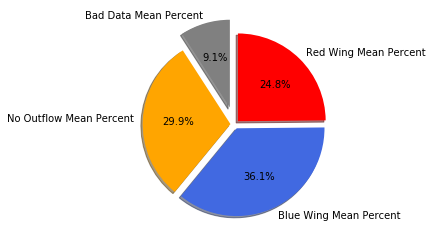

In [19]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Bad Data Mean Percent', 'No Outflow Mean Percent', 'Blue Wing Mean Percent', 'Red Wing Mean Percent'
sizes = [bad_data_mean, no_outflow_mean, blu_wing_mean, red_wing_mean]
explode = (0.2, 0.05, 0.05, 0.05)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ('grey', 'orange', 'royalblue', 'red'))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [45]:
percents

array([[ 40., 112., 150., 107.],
       [ 35., 124., 155.,  95.],
       [ 38., 137., 137.,  97.],
       [ 30., 123., 156., 100.],
       [ 39., 121., 146., 103.],
       [ 33., 124., 146., 106.],
       [ 33., 128., 146., 102.],
       [ 41., 126., 150.,  92.],
       [ 36., 126., 141., 106.],
       [ 40., 120., 141., 108.],
       [ 38., 133., 137., 101.],
       [ 34., 119., 153., 103.],
       [ 32., 131., 149.,  97.],
       [ 38., 124., 144., 103.],
       [ 36., 127., 149.,  97.],
       [ 35., 129., 138., 107.],
       [ 38., 113., 151., 107.],
       [ 34., 130., 150.,  95.],
       [ 43., 122., 152.,  92.],
       [ 38., 127., 149.,  95.],
       [ 38., 128., 146.,  97.],
       [ 32., 125., 157.,  95.],
       [ 38., 130., 138., 103.],
       [ 39., 121., 149., 100.],
       [ 34., 127., 142., 106.],
       [ 39., 119., 154.,  97.],
       [ 35., 127., 144., 103.],
       [ 31., 119., 144., 115.],
       [ 40., 133., 140.,  96.],
       [ 36., 125., 149.,  99.],
       [ 3

In [ ]:
#0 bad data, 1 no outflow, 2 blu wing, 3 red wing, 4 broad comp, no outflow


In [65]:
sum_rcsq = 0
good_count = 0

for s in trimmed_specs:
    OIII_wave = trimmed_specs[s][0]
    OIII_fluxden = trimmed_specs[s][1]
    k = trimmed_specs[s][2]
    OIII_error = trimmed_specs[s][3]
    
    try:
    
        similarity1 = np.sum(((OIII_fluxden - fit) / OIII_error) ** 2) #take csq between current data in iteration and fits from preset
        similarity2 = similarity1 / len(OIII_fluxden) #divide by length for reduced chi squared
        
    except:
    
        similarity1 = np.sum(((OIII_fluxden - fit[1::]) / OIII_error) ** 2) #take csq between current data in iteration and fits from preset
        similarity2 = similarity1 / len(OIII_fluxden) #divide by length for reduced chi squared
    
    sum_rcsq += similarity2
    print(similarity2)
    if similarity2 <= 40:
        good_count += 1

avg_rcsq = sum_rcsq / len(trimmed_specs)
print(avg_rcsq)
print(good_count)

108.39346384447674
672.1320403343024
333.0550281613372
419.9112917877907
197.33904887354652
275.89814226017444
47.08718375272529
54.067695085392444
172.63458393895348
206.2643531976744
172.10835301598837
166.30545966569767
154.1917014898256
20.951288396661933
2509.0708575581393
511.47451853197674
170.31925644985466
144.7944449491279
30.132304346838662
81.93556958575581
32.477880304509945
350.1819513494318
620.0732648982558
215.2355105377907
10.813362815163352
115.85411746002907
660.8743640988372
30.703485662286933
57.14297762784091
95.02585051780524
1525.5168678977273
1185.7560864825582
592.8698673691861
632.2738813920455
533.0588600852273
29.95390458540483
76.79510356104652
89.0751953125
73.3410810990767
352.35047238372096
17.058764080668606
952.4206031976744
400.43856534090907
477.63081498579544
6779.462357954545
26.809703738190407
3445.1022727272725
21.715408325195312
117.07441179142442
4631.915838068182
117.74863503196023
457.9580759447674
286.8016896802326
309.3634144176136
44.975

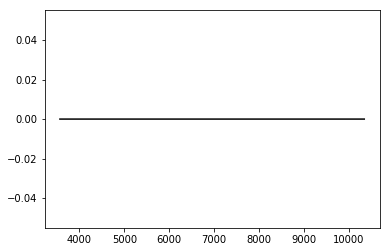

In [37]:
######################
##### TEST CELL ######
######################

spectrum = 'spec-6190-56210-0880'

wave = spec[spectrum][0]
fluxden = spec[spectrum][1]
k = spec[spectrum][2]
error = spec[spectrum][3]

plt.plot(wave, fluxden, 'k-')
plt.show()

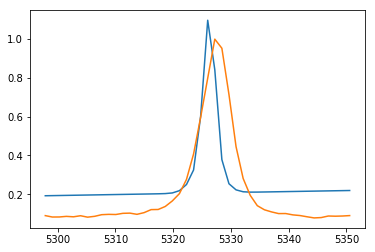

In [22]:
x = OIII_wave
y1 = OIII_fluxden
p = np.array([7.24534493e-01, 1.91300377e+04, 1.41000000e+02, 1.97600316e-01, 1.91109344e+04, 3.00000000e+02, 5.13002925e-04, -2.52572122e+00])
y = double_gaussian_lincont(x, p)
plt.plot(x, y)
plt.plot(x, y1)
plt.show()

In [54]:
n = np.zeros(shape = (5,9))
p = np.random.normal(size = 8)
print(n)
print('-')
c = 0
for r in n:
    r[0] = np.abs(np.random.normal())
    r[1::] = np.random.normal(size = 8)
    c += 1
    
print(n)
print('-')
best_rcsq = np.min(n[:,0])

print(best_rcsq)
print('-')
for r in n:
    if r[0] == best_rcsq:
        best_params = (r[1::])
        print(best_params)



[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
-
[[ 0.32111153  0.55891718  1.2714504  -0.37483415  0.85730581 -0.71175797
   1.80931558 -0.51330737 -0.82696608]
 [ 0.4382245   0.25673814 -0.77895185  2.28830824  1.01344948 -0.60976432
   1.2388983   0.70041699  1.363101  ]
 [ 1.05844687  0.619107    0.68904972 -2.10427429  0.87430659  1.52863136
   0.48017944 -0.08828415  1.0385529 ]
 [ 1.50901199 -0.84734919  0.24431953 -0.60459708  0.62669075 -0.90249538
  -0.77240594  1.04390586  0.64119949]
 [ 1.15966127  0.48878378  0.52350459  2.27297802  1.53972926 -0.14532128
   1.44899101  0.68584464 -0.12464404]]
-
0.32111153035028756
-
[ 0.55891718  1.2714504  -0.37483415  0.85730581 -0.71175797  1.80931558
 -0.51330737 -0.82696608]


In [43]:
p = {}

p.update({'s':123})

p.update({'r':456})

p['s']

123

In [ ]:
###############################
###############################

#good model for 05-05-2020 1:33PM

###############################
###############################

avg_rcsq = []
preset_parameters = {} #called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID, fit
flags = []

for s in trimmed_specs: #loop and use the fit on all the trimmed specs
    
    used_preset = False #by default use the generic initial conditions

    OIII_wave = trimmed_specs[s][0] #array with wavelength values for the current spectrum in angstrom
    OIII_fluxden = trimmed_specs[s][1] #array with corresponding flux density values
    k = trimmed_specs[s][2] #corresponding z + 1 value
    OIII_error = trimmed_specs[s][3] #array with corresponding flux density error values
    
    ###############################
    ###############################
    
    specific_presets = {} #prepare a dictionary with velocity means corrected for the current spectrum's k value

    for p in preset_parameters: #for every key in the preset parameters
        
    ###############################
    ###############################
        
        k_corrected_parameters = preset_parameters[p][0] #take the parameters first 
        
    ###############################
    
#     Using z = v / c
    
#     z1 / v1 = c = z2 / v2
    
#     v2 = (z2 / z1) * v1
    
#     z2 = k_spectrum - 1

#     z1 = k_fit - 1
    
    ###############################
        
        k_corrected_parameters[1] = ((k - 1)/(preset_parameters[p][1] - 1)) * k_corrected_parameters[1]
        k_corrected_parameters[4] = ((k - 1)/(preset_parameters[p][1] - 1)) * k_corrected_parameters[4]
        
    ###############################
#   
    
#     Sometimes get a problem with the above
    
#   
    ###############################
        
        #if the angstrom value of the mean is not within the wavelength range, then bring it back into the range for both means
        if to_angstrom_OIII(k_corrected_parameters[1]) >= OIII_wave[-1] or to_angstrom_OIII(k_corrected_parameters[1]) <= OIII_wave[0]:
            k_corrected_parameters[1] = (k - 1) * 300000
         
        if to_angstrom_OIII(k_corrected_parameters[4]) >= OIII_wave[-1] or to_angstrom_OIII(k_corrected_parameters[4]) <= OIII_wave[0]:
            k_corrected_parameters[4] = (k - 1) * 300000
            
        #if it turns out that both are not in the range, make generic velocity means and keep widths and amplitudes
        if k_corrected_parameters[1] == k_corrected_parameters[4]:
            k_corrected_parameters[1] = to_vel_OIII(5007*k)
            k_corrected_parameters[4] = identify_wing(OIII_wave, OIII_fluxden, k)
        
        specific_presets.update({p:k_corrected_parameters}) #update the specific presets dictionary with the k corrected velocity means
    
    if len(preset_parameters) == 0: #this is for the first iteration
        similarity_table = np.zeros(shape = (1, 9)) #make a single row with [0] the rcsq, [1:8] parameters, filled with zeros
        similarity_table[0][0] = np.inf #set the rcsq value to infinity to force generic parameters because there are no presets to try
        
    else:
        similarity_table = np.zeros(shape = (len(preset_parameters), 9)) #create empty array to store rcsq and parameters used to generate them
    
    ###############################
    ###############################
    
    #generate initial parameters
    
    ###############################
    ###############################
    
    double_gaussian_parameters = double_gauss_params(OIII_wave, OIII_fluxden, k) #generate generic parameters
    
    parameters_counter = 0 #used to loop down the similarity table
    
    for p in specific_presets: #try to see if can get better starting parameters from the previously done spectra
        
        similarity1 = np.sum(((OIII_fluxden - double_gaussian_lincont(OIII_wave, specific_presets[p])) / OIII_error) ** 2) #take csq between current data in iteration and fits from preset
        similarity2 = similarity1 / len(OIII_fluxden) #divide by length for reduced chi squared
                                        
        similarity_table[parameters_counter][0] = similarity2 #parameters_counter gives row, first entry is the similiarity2, rcsq for the current parameters being tested
        similarity_table[parameters_counter][1::] = specific_presets[p] #set the rest of the row to the parameters used to generate the similarity2, rcsq
        parameters_counter += 1

    best_rcsq = np.min(similarity_table[:,0]) #identify the lowest value in the first column, the best rcsq
    
    ###############################
    ###############################
    
    initial_conditions = np.zeros(shape = (1, 8)) #make an empty array with enough space to hold the 8 parameters
    
    ###############################
    ###############################
    
    try: #will almost always use this
        if best_rcsq <= 40: #arbitrary guess, seems to give lowest average rcsq

            used_preset = True #note that a preset was used, do not update the dictionary with this fit
            
            initial_conditions = similarity_table[np.where(similarity_table[:,0] == best_rcsq)][0][1::] #find the row corresponding to the lowest rcsq value and set the initial conditions to those parameters

        else:
            initial_conditions = double_gaussian_parameters #if the best rcsq isn't lower than 40 (again, arbitrary guess) then force the generic parameters
    
    except: #iterations with a 0 length preset parameters may run into an error, force generic parameters in that case
        initial_conditions = double_gaussian_parameters
    
    ###############################
    ###############################
    
    fit_params = leastsq(double_gaussian_lincont_fit, x0 = initial_conditions, args = (OIII_wave, OIII_fluxden, OIII_error), maxfev = 100000) #call the least squares fit using which ever initial conditions were used
    
    params = fit_params[0] #take only the parameters
     
    fit = double_gaussian_lincont(OIII_wave, params) #generate y values for the fit
    
    csq = np.sum(((OIII_fluxden - double_gaussian_lincont(OIII_wave, params)) / OIII_error) ** 2) #take csq between current data in iteration and fits from preset
    rcsq = csq / len(OIII_fluxden) #divide by length for reduced chi squared
    
    ###############################
    ###############################
    
    if used_preset == False: #if a preset was not used, then update a new preset in the dictionary with this fit
        preset_parameters.update({s:[params, k]}) #0 fit parameters, 1 k value
    
    flag = flag_spec(fit_params, OIII_wave, OIII_fluxden, OIII_error) #flag the data with the following
    
    #0 bad data, 1 no outflow, 2 blu wing, 3 red wing, 4 broad comp, no outflow
    
    flags.append(flag)

# print('-')
# print(np.mean(avg_rcsq))
flags = np.array(flags) #convert the list into an array for faster processing
unique, counts = np.unique(flags, return_counts=True) #count occurences of each flag
ye = dict(zip(unique, counts)) #put into dictionary
print(ye) #print the dictionary to view the wing values

In [28]:
test = np.zeros((1, 12))
for n in range(3):
    test[0][(n + 2)] = 7

In [34]:
print(test[0][0:8])
test[0][2:5] = 9
print(test[0][0:8])

[0. 0. 7. 7. 7. 0. 0. 0.]
[0. 0. 9. 9. 9. 0. 0. 0.]
